# Spatial weights

In this session we will be learning the ins and outs of one of the key pieces in spatial analysis: spatial weights matrices. These are structured sets of numbers that formalize geographical relationships between the observations in a dataset. Essentially, a spatial weights matrix of a given geography is a positive definite matrix of dimensions $N$ by $N$, where $N$ is the total number of observations:

$$
W = \left( \begin{array}{ccc}
0 & w_{12} & \dots & w_{1N} \\
w_{21} & \ddots & w_{ij} & \vdots \\
\vdots & w_{ji} & 0 & \vdots \\
w_{N1} & \dots & \dots & 0 \end{array} \right)
$$

where each cell $w_{ij}$ contains a value that represents the degree of spatial contact or interaction between observations $i$ and $j$. A fundamental concept in this context is that of *neighbor* and *neighborhood*. A *neighbor* of a given observation $i$ is another observation with which $i$ has some degree of connection. In terms of $W$, $i$ and $j$ are thus neighbors if $w_{ij} > 0$. Following this logic, the neighborhood of $i$ will be the set of observations in the system with which it has certain connection, or those observations with a weight greater than zero.

There are several ways to create such matrices, and many more to transform them so they contain an accurate representation that aligns with the way we understand spatial interactions between the elements of a system. In this session, we will introduce the most commonly used ones and will show how to compute them with `PySAL`.

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## Data

For this tutorial, we will use again the recently released 2015 Index of Multiple Deprivation (IMD) for England and Wales. This dataset can be most easily downloaded from the CDRC data store ([link](https://data.cdrc.ac.uk/dataset/cdrc-english-indices-of-deprivation-2015-geodata-pack-liverpool-e08000012)) and, since it already comes both in tabular as well as spatial data format (shapefile), it does not need merging or joining to additional geometries.

In addition, we will be using the lookup between LSOAs and Medium Super Output Areas (MSOAs), which can be downloaded on this [link](http://www.ons.gov.uk/ons/external-links/social-media/g-m/2011-oas-to-2011-lower-layer-super-output-areas--lsoas---middle-layer-super-output-areas--msoa--and-lads.html). This connects each LSOA polygon to the MSOA they belong to. MSOAs are a coarser geographic delineation from the Office of National Statistics (ONS), within which LSOAs are nested. That is, no LSOA boundary crosses any of an MSOA.

As usual, let us set the paths to the folders containing the files before anything so we can then focus on data analysis exclusively (keep in mind the specific paths will probably be different for your computer):

In [2]:
# This will be different on your computer and will depend on where
# you have downloaded the files
imd_shp = '../../../../data/E08000012_IMD/shapefiles/E08000012.shp'
lookup_path = '../../../../data/Output_areas_(2011)_to_lower_layer_super_output_areas_(2011)_to_middle_layer_super_output_areas_(2011)_to_local_authority_districts_(2011)_E+W_lookup/'

Let us load the IMD data first:

In [3]:
# Read the file in
imd = gpd.read_file(imd_shp)
# Index it on the LSOA ID
imd = imd.set_index('LSOA11CD')
# Display summary
imd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 298 entries, E01006512 to E01033768
Data columns (total 12 columns):
crime         298 non-null float64
education     298 non-null float64
employment    298 non-null float64
geometry      298 non-null object
health        298 non-null float64
housing       298 non-null float64
idaci         298 non-null float64
idaopi        298 non-null float64
imd_rank      298 non-null int64
imd_score     298 non-null float64
income        298 non-null float64
living_env    298 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 30.3+ KB


## Building spatial weights in `PySAL`

### Contiguity

Contiguity weights matrices define spatial connections through the existence of common boundaries. This makes it directly suitable to use with polygons: if two polygons share boundaries to some degree, they will be labeled as neighbors under these kinds of weights. Exactly how much they need to share is what differenciates the two approaches we will learn: queen and rook.

* **Queen**

Named after the game of chess, two observations only need to share a vortex (a single point) of their boundaries to be considered neighbors under the queen criterion. Constructing a weights matrix under these principles can be done by running:

In [4]:
w_queen = ps.queen_from_shapefile(imd_shp, idVariable='LSOA11CD')
w_queen

The command above creates an object `w_queen` of the class `W`. This is the format in which spatial weights matrices are stored in `PySAL`. Note how we include the attribute `idVariable` and pass in `LSOA11CD`. This ensures that the observations are recorded using the ID codes we are used to, and also that we are using to index the table `imd`. This way we can keep everything in line easily.

A `W` object can be queried to find out about the contiguity relations it contains. For example, if we would like to know who is a neighbor of observation `E01006690`:

In [17]:
w_queen['E01006690']

{'E01006691': 1.0,
 'E01006692': 1.0,
 'E01006695': 1.0,
 'E01006697': 1.0,
 'E01006720': 1.0,
 'E01006759': 1.0,
 'E01033763': 1.0}

This returns a Python dictionary that contains the ID codes of each neighbor as keys, and the weights they are assigned as values. Since we are looking at a raw queen contiguity matrix, every neighbor gets a weight of one. If we want to access the weight of a specific neighbor, of `E01006691`, for example:

In [18]:
w_queen['E01006690']['E01006691']

1.0

`W` objects also have a direct way to provide a list of all the neighbors or their weights for a given observation. This is thanks to the `neighbors` and `weights` attributes:

In [19]:
w_queen.neighbors['E01006690']

['E01006720',
 'E01033763',
 'E01006691',
 'E01006692',
 'E01006695',
 'E01006697',
 'E01006759']

In [20]:
w_queen.weights['E01006690']

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Once created, `W` objects can provide much information about the matrix, beyond the basic attributes one would expect.

Check [Weights tutorial](http://pysal.readthedocs.org/en/latest/users/tutorials/weights.html).

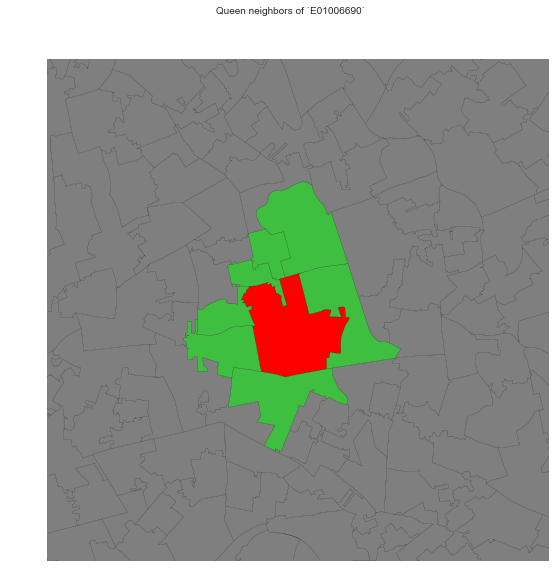

In [170]:
# Setup figure
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot base layer of polygons
for poly in imd['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, facecolor='k', linewidth=0.1)
# Select focal polygon
focus = imd.loc['E01006690', 'geometry']
# Plot focal polygon
gpd.plotting.plot_multipolygon(ax, focus, facecolor='red', alpha=1, linewidth=0)
# Plot neighbors
for nei in w_queen['E01006690']:
    nei_poly = imd.loc[nei, 'geometry']
    gpd.plotting.plot_multipolygon(ax, nei_poly, facecolor='lime', linewidth=0)
# Title
f.suptitle("Queen neighbors of `E01006690`")
# Style and display on screen
ax.set_axis_off()
plt.axis('equal')
ax.set_ylim(388000, 393500)
ax.set_xlim(336000, 339500)
plt.show()

* **Rook**

In [23]:
w_rook = ps.rook_from_shapefile(imd_shp, idVariable='LSOA11CD')
w_rook

---

**[Optional exercise]**

Create a similar map for the rook neighbors of polygon `E01006580`. How would it differ if the spatial weights were created based on the queen criterion?

---

### Distance

* **K-Nearest Neighbors**

* **Inverse distance**

In [5]:
w_dist1km = ps.threshold_binaryW_from_shapefile(imd_shp, 1000, idVariable='LSOA11CD')

---

**[Optional extension. Lecture figure]**

Below is how to build a visualization for distance-based weights that displays the polygons, highlighting the focus and its neighbors, and then overlays the centroids and the buffer used to decide whether a polygon is a neighbor or not. Since this is distance-based weights, there needs to be a way to establish distance between two polygons and, in this case, the distance between their centroids is used.

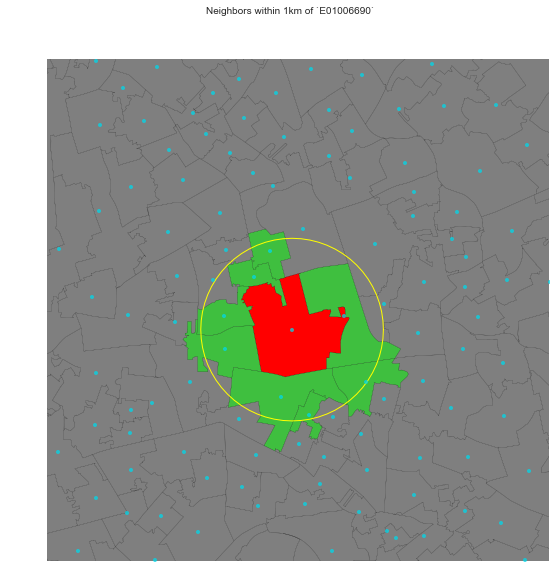

In [171]:
# Setup figure
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot base layer of polygons
for poly in imd['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, facecolor='k', linewidth=0.1)
# Select focal polygon
focus = imd.loc['E01006690', 'geometry']
# Plot focal polygon
gpd.plotting.plot_multipolygon(ax, focus, facecolor='red', alpha=1, linewidth=0)
# Plot neighbors
for nei in w_dist1km['E01006690']:
    nei_poly = imd.loc[nei, 'geometry']
    gpd.plotting.plot_multipolygon(ax, nei_poly, facecolor='lime', linewidth=0)
# Plot 1km buffer
buf = focus.centroid.buffer(1000)
gpd.plotting.plot_multipolygon(ax, buf, edgecolor='yellow', alpha=0)
# Plot centroids of neighbor
pts = np.array([(pt.x, pt.y) for pt in imd.centroid])
ax.plot(pts[:, 0], pts[:, 1], color='#00d8ea', linewidth=0, alpha=0.75, marker='o', markersize=4)
#imd.centroid.plot(axes=ax)
# Title
f.suptitle("Neighbors within 1km of `E01006690`")
# Style, zoom and display on screen
ax.set_axis_off()
plt.axis('equal')
ax.set_ylim(388000, 393500)
ax.set_xlim(336000, 339500)
plt.show()

---

### Block weights

For this case, we will build a spatial weights matrix that connects every LSOA with all the other ones in the same MSOA. To do this, we first need a lookup list that connects both kinds of geographies:

In [144]:
lookup = pd.read_csv(lookup_path+'OA11_LSOA11_MSOA11_LAD11_EW_LUv2.csv')
lookup = lookup[['LSOA11CD', 'MSOA11CD']].drop_duplicates(take_last=True)\
                                         .set_index('LSOA11CD')['MSOA11CD']
lookup.head()

LSOA11CD
E01000002    E02000001
E01032740    E02000001
E01000005    E02000001
E01000009    E02000017
E01000008    E02000016
Name: MSOA11CD, dtype: object

Since the original file contains much more information than we need for this exercise, note how in line 2 we limit the columns we keep to only two, `LSOA11CD` and `MSOA11CD`. We also add an additional command, `drop_duplicates`, which removes elements whose index is repeated more than once, as is the case in this dataset (every LSOA has more than one row in this table). By adding the `take_last` argument, we make sure that one and only one element of each index value is retained. For ease of use later on, we set the index, that is the name of the rows, to `LSOA11CD`. This will allow us to perform easy lookups without having to perform full `DataFrame` queries, and it is also a more computationally efficient way to select observations.

For example, if we want to know in which MSOA the polygon `E01000003` is, we just need to type:

In [147]:
lookup.loc['E01000003']

'E02000001'

With the lookup in hand, let us append it to the IMD table to keep all the necessary pieces in one place only:

In [149]:
imd['MSOA11CD'] = lookup

Now we are ready to build a block spatial weights matrix that connects as neighbors all the LSOAs in the same MSOA. Using `PySAL`, this is a one-line task:

In [154]:
w_block = ps.block_weights(imd['MSOA11CD'])

In this case, `PySAL` does not allow to pass the argument `idVariable` as above. As a result, observations are named after the the order the occupy in the list:

In [156]:
w_block[0]

{218: 1.0, 219: 1.0, 220: 1.0, 292: 1.0}

The first element is neighbor of observations 218, 129, 220, and 292, all of them with an assigned weight of 1. However, it is easy enough to correct this by using the additional method `remap_ids`:

In [161]:
w_block.remap_ids(imd.index)

Now if you try `w_bloc[0]`, it will return an error. But if you query for the neighbors of an observation by its LSOA id, it will work:

In [167]:
w_block['E01006512']

{u'E01006747': 1.0, u'E01006748': 1.0, u'E01006751': 1.0, u'E01033763': 1.0}

---

**[Optional exercise]**

For block weights, create a similar map to that of queen neighbors of polygon `E01006690`.

---

## Standardizing `W` matrices

In [176]:
w_queen['E01006690']

{'E01006691': 1.0,
 'E01006692': 1.0,
 'E01006695': 1.0,
 'E01006697': 1.0,
 'E01006720': 1.0,
 'E01006759': 1.0,
 'E01033763': 1.0}

In [178]:
w_queen.transform

'O'

In [179]:
w_queen.transform = 'R'

In [180]:
w_queen['E01006690']

{'E01006691': 0.14285714285714285,
 'E01006692': 0.14285714285714285,
 'E01006695': 0.14285714285714285,
 'E01006697': 0.14285714285714285,
 'E01006720': 0.14285714285714285,
 'E01006759': 0.14285714285714285,
 'E01033763': 0.14285714285714285}

In [182]:
pd.Series(w_queen['E01006690']).sum()

0.99999999999999978

In [183]:
w_queen.transform = 'O'

In [184]:
w_queen['E01006690']

{'E01006691': 1.0,
 'E01006692': 1.0,
 'E01006695': 1.0,
 'E01006697': 1.0,
 'E01006720': 1.0,
 'E01006759': 1.0,
 'E01033763': 1.0}

## Reading and Writing spatial weights in `PySAL`

Sometimes, if a dataset is very detailed or large, it can be costly to build the spatial weights matrix of a given geography and, despite the optimizations in the `PySAL` code, the computation time can quickly grow out of hand. In these contexts, it is useful to not have to re-build a matrix from scratch every time we need to re-run the analysis. A useful solution in this case is to build the matrix once, and save it to a file where it can be reloaded at a later stage if needed.

`PySAL` has a common way to write any kind of `W` object into a file using the command `open`. The only element we need to decide for ourselves beforehand is the format of the file. Although there are several formats in which spatial weight matrices can be stored (have a look at the [list](http://pysal.readthedocs.org/en/latest/users/tutorials/fileio.html) of supported ones by `PySAL`), we will focused on the two most commonly used ones:

* **`.gal`** files for contiguity weights

Contiguity spatial weights can be saved into a `.gal` file with the following commands:

In [7]:
# Open file to write into
fo = ps.open('imd_queen.gal', 'w')
# Write the matrix into the file
fo.write(w_queen)
# Close the file
fo.close()

The process is composed by the following three steps:

1. Open a target file for `w`riting the matrix, hence the `w` argument. In this case, if a file `imd_queen.gal` already exists, it will be overwritten, so be careful.
1. Write the `W` object into the file.
1. Close the file. This is important as some additional information is written into the file at this stage, so failing to close the file might have unintended consequences.

Once we have the file written, it is possible to read it back into memory with the following command:

In [8]:
w_queen2 = ps.open('imd_queen.gal', 'r').read()
w_queen2

Note how we now use `r` instead of `w` because we are `r`eading the file, and also notice how we open the file and, in the same line, we call `read()` directly.

* **`.gwt`** files for distance-based weights.

A very similar process to the one above can be used to read and write distance based weights. The only difference is specifying the right file format, `.gwt` in this case. So, if we want to write `w_dist1km` into a file, we will run:

In [6]:
# Open file
fo = ps.open('imd_dist1km.gwt', 'w')
# Write matrix into the file
fo.write(w_dist1km)
# Close file
fo.close()

And if we want to read the file back in, all we need to do is:

In [15]:
w_dist1km2 = ps.open('imd_dist1km.gwt', 'r').read()

Note how, in this case, you will probably receive a warning alerting you that there was not a `DBF` relating to the file. This is because, by default, `PySAL` takes the order of the observations in a `.gwt` from a shapefile. If this is not provided, `PySAL` cannot entirely determine all the elements and hence the resulting `W` might not be complete (islands, for example, can be missing). To fully complete the reading of the file, we can remap the ids as we have seen above:

In [14]:
w_dist1km2.remap_ids(imd.index)

## Spatial Lag

In [191]:
w_queen.transform = 'R'
w_queen_score = ps.lag_spatial(w_queen, imd['imd_score'])
w_queen_score

array([ 48.27833333,  34.96777778,  46.538     ,  40.02375   ,
        63.738     ,  15.186     ,  44.95714286,  28.94833333,
        30.52428571,  31.63      ,  19.00666667,  13.07857143,
        24.07285714,  11.91      ,  19.08333333,  20.872     ,
        20.588     ,  20.8225    ,  22.61833333,  20.18      ,
        26.54      ,  26.27666667,  29.52166667,  34.0325    ,
        36.095     ,  12.25285714,  73.82      ,  50.20444444,
        63.29      ,  51.466     ,  53.36333333,  61.93      ,
        66.624     ,  67.7725    ,  74.78833333,  44.68714286,
        24.04      ,  26.9       ,  62.3825    ,  20.87428571,
        31.19      ,  49.96888889,  36.54166667,  70.8275    ,
        70.08285714,  69.16166667,  69.56142857,  72.504     ,
        42.474     ,  45.63833333,  37.17571429,  38.31428571,
        32.295     ,  35.3       ,  46.99333333,  54.71      ,
        43.072     ,  59.825     ,  28.53625   ,  20.354     ,
        20.082     ,  20.53      ,  15.34285714,  17.05

---

**[Optional exercise]**

Explore the spatial lag of `w_queen_score` by constructing a density/histogram plot similar to those created in Lab 2. Compare these with one for `imd_score`. What differences can you tell?

<!--
sns.distplot(imd['imd_score'])

sns.distplot(imd['w_queen_score'])
-->

---

## Moran Plot

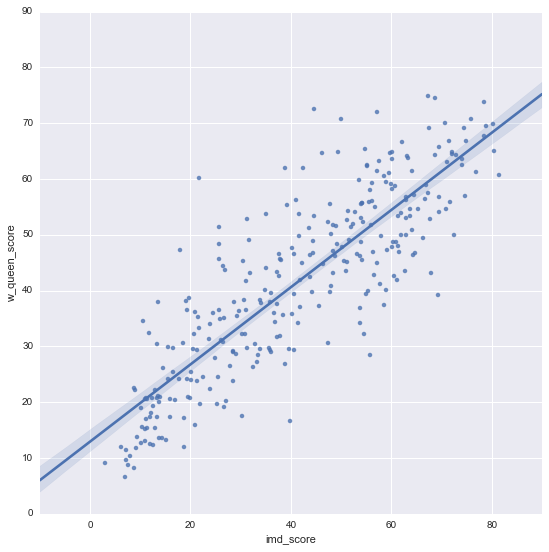

In [235]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x="imd_score", y="w_queen_score", data=imd)
# Display
plt.show()

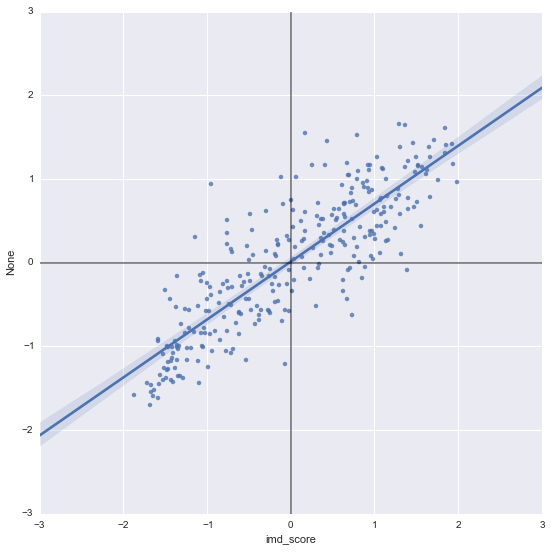

In [236]:
# Standardize the IMD scores
std_imd = (imd['imd_score'] - imd['imd_score'].mean()) / imd['imd_score'].std()
# Compute the spatial lag of the standardized version and save is as a 
# Series indexed as the original variable
std_w_imd = pd.Series(ps.lag_spatial(w_queen, std_imd), index=std_imd.index)
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_imd, y=std_w_imd)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

---

**[Optional exercise]**

Create a standardized Moran Plot for each of the components of the IMD:

* Crime
* Education
* Employment
* Health
* Housing
* Income
* Living environment

**Bonus** if you can generate all the plots with a `for` loop.

**Bonus-II** if you explore the functionality of Seaborn's `jointplot` ([link](http://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#plotting-a-regression-in-other-contexts) and [link](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.jointplot.html#seaborn.jointplot)) to create a richer Moran plot.

<!--
w_queen.transform = 'R'
for col in ['crime', 'education', 'employment', 'health', 'housing', 'income', 'living_env']:
    stdd = (imd[col] - imd[col].mean()) / imd[col].std()
    sl = pd.Series(ps.lag_spatial(w_queen, stdd), index=stdd.index)
    sns.jointplot(x=stdd, y=sl, kind="reg")
-->

---

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geographic Data Science'15 - Lab 5</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://darribas.org" property="cc:attributionName" rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

